In [1]:
import time
import json
from functools import wraps
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

import vk
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd

import numpy as np
from numpy.linalg import norm

from sklearn.cluster import SpectralClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Imputer

In [2]:
cache_filename = 'graph_vertex_cache.json'

In [3]:
with open("author.txt") as f:
    login = f.readline().rstrip()
    passwd = f.readline().rstrip()

session = vk.AuthSession(app_id='6070120', user_login=login, user_password=passwd)

api = vk.API(session)
api_version = "5.73"


requests_count = 0

## Load graph cache dictionary from file if possible

In [4]:
try:
    cache_dict = json.load(open(cache_filename, 'r'))
except FileNotFoundError:
    cache_dict = {}
    
cache_dict = {int(k): val for k, val in cache_dict.items()}

## Construct a graph

#### Necessary decorators

In [5]:
# decorator that handles sleeping
def vk_requester(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        global requests_count
        if requests_count == 3:
            requests_count = 0
            time.sleep(1)
        try:
            requests_count += 1
            return_val = request_func(*args, **kwargs)
        except vk.exceptions.VkAPIError as err:
            if err.code in (6, 10): # too many requests per second or internal server error
                time.sleep(1)
                requests_count += 1
                return_val = request_func(*args, **kwargs)
            else:
                raise err
        return return_val
    return wrapper

In [6]:
def request_list(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        return_val = request_func(*args, **kwargs)
        if isinstance(return_val, list):
            return return_val
        else:
            return list(return_val['items'])
    return wrapper

def handle_friends_exceptions(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        try:
            return_val = request_func(*args, **kwargs)
        except vk.exceptions.VkAPIError as err:
            if err.code == 18: # deleted or banned user
                return_val = []
            else:
                raise err
        return return_val
    return wrapper

In [7]:
@request_list
@handle_friends_exceptions
@vk_requester
def get_friends(api, api_version, user_id):
    return api.friends.get(user_id=user_id, v=api_version)

#### Custom `Graph` wrapper for `nx.Graph`

In [8]:
class Graph(nx.Graph):    
    def __init__(self, start_id, waves, *args, **kwargs):
        super(Graph, self).__init__(*args, **kwargs)
        self.start_id = start_id
        self.waves = waves
        self.nodes_waves = {wave: [] for wave in range(waves)}
        self.nodes_waves[waves] = [start_id]

    def reverse_waves(self):
        self.nodes_waves = {self.waves - key: val for key, val in self.nodes_waves.items()}

#### Functions responsible for graph construction

In [9]:
def construct_graph(user_id, output_graph, wave=3):
    output_graph.add_node(user_id)
    
    global cache_dict

    if user_id in cache_dict:
        friends = cache_dict[user_id]
    else:
        #print("{} not found in cache".format(user_id))
        friends = get_friends(api, api_version, user_id)
        cache_dict[user_id] = friends

    # add each friendship and dive deeper
    for friend in friends:
        friend_in_graph = friend in output_graph
        if wave != 0 and not friend_in_graph:
            output_graph.nodes_waves[wave - 1].append(friend)
            construct_graph(friend, output_graph, wave - 1)
        if wave == 0 and not friend_in_graph:
            continue

        output_graph.add_edge(user_id, friend)
        
        
def construct_graph_from_cache(user_id, output_graph, wave=3):
    output_graph.add_node(user_id)
    
    if user_id in cache_dict:
        friends = cache_dict[user_id]
        for friend in friends:
            friend_in_graph = friend in output_graph
            if wave != 0 and not friend_in_graph:
                output_graph.nodes_waves[wave - 1].append(friend)
                construct_graph_from_cache(friend, output_graph, wave - 1)
            if wave == 0 and not friend_in_graph:
                continue
                
            output_graph.add_edge(user_id, friend)
            
            
def create_graph(start_id, waves, constructor, graph=None):
    if not graph:
        graph = Graph(start_id, waves)
    
    constructor(graph.start_id, graph, graph.waves)
    graph.reverse_waves()
    
    return graph

In [10]:
class MyCoolException(Exception):
    pass

In [11]:
start_id = 10938483 # my id

#### Construct graph via requests

In [ ]:
%%time
cache_dict = {}
main_graph = Graph(start_id, waves=4)
while True:
    try:
        main_graph = create_graph(start_id, 4, construct_graph, main_graph)
        raise MyCoolException()
    except Exception as err:
        if isinstance(err, MyCoolException):
            break

In [19]:
len(main_graph.nodes())

0

In [ ]:
%%time
cache_dict = {}
main_graph = Graph(start_id, waves=4)
exceptions = 0
while True:
    try:
        create_graph(start_id, 4, construct_graph, main_graph)
        raise MyCoolException()
    except Exception as err:
        exceptions += 1
        if isinstance(err, ReadTimeout):
            print('timeout {}'.format(exceptions))
            continue
        if isinstance(err, MyCoolException):
            break


In [ ]:
%%time
main_graph = Graph(start_id, waves=4)
while True:
    try:
        construct_graph(main_graph.start_id, main_graph, main_graph.waves)
        
        main_graph.reverse_waves()
        raise MyCoolException()
    except Exception as err:
        if isinstance(err, MyCoolException):
            break


#### Create the cache file

In [ ]:
'''
with open(cache_filename, 'w') as f:
    json.dump(cache_dict, f)
'''

#### Construct smaller graph from cache

In [14]:
%%time
graph_piece = create_graph(start_id, 2, construct_graph_from_cache)

CPU times: user 130 ms, sys: 7.16 ms, total: 137 ms
Wall time: 139 ms


In [15]:
%%time
main_graph = create_graph(start_id, 4, construct_graph_from_cache)

CPU times: user 47.4 s, sys: 17.8 s, total: 1min 5s
Wall time: 2min 10s


In [15]:
len(graph_piece)

3689

In [16]:
nx.adj_matrix(graph_piece)

<3689x3689 sparse matrix of type '<class 'numpy.int64'>'
	with 12836 stored elements in Compressed Sparse Row format>

## Visualize the graph

In [37]:
%%time
pos_shell = nx.shell_layout(graph_piece, list(map(lambda x: x[1], sorted(graph_piece.nodes_waves.items(), reverse=True))))

CPU times: user 10.3 ms, sys: 3.54 ms, total: 13.8 ms
Wall time: 16.9 ms


In [38]:
%%time
pos_spring = nx.spring_layout(graph_piece)

CPU times: user 48.5 s, sys: 0 ns, total: 48.5 s
Wall time: 48.9 s


In [255]:
colors = ['#ff0000', '#ffe100', '#207a2e', '#58fcfa', '#0004ff', '#b600ff', '#ff0083', '#96502d', '#000000']


CPU times: user 4.87 s, sys: 336 ms, total: 5.2 s
Wall time: 4.82 s


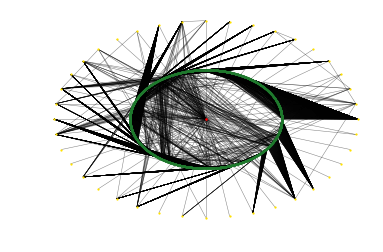

In [256]:
%%time
#nx.draw(main_graph, pos=pos, node_color='pink', edge_color='black', node_size=1)

def draw_graph_waves(graph, pos, filename, labels_nodes):
    n_labels = len(labels_nodes)
    for ind, (label, nodes) in enumerate(sorted(labels_nodes.items(), reverse=True)):
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=colors[(n_labels - ind - 1) % len(colors)], node_size=ind + .5)
    nx.draw_networkx_edges(graph, pos, width=0.5, alpha=0.5)

    plt.axis('off')
    plt.savefig("{}.png".format(filename), dpi=1000, orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1) 

draw_graph_waves(graph_piece, pos_shell, 'graph_shell', graph_piece.nodes_waves)

## Form dataset from graph nodes

In [18]:
@vk_requester
def get_users(api, api_version, user_ids, fields):
    return api.users.get(user_ids=user_ids, fields=fields, v=api_version)

In [19]:
@request_list
@vk_requester
def get_groups(api, api_version, user_ids, fields):
    return api.groups.get(user_ids=user_ids, extended=1, fields=fields, v=api_version)

In [20]:
features_fields = ['uid', 'first_name', 'last_name', 'deactivated', 
                   'bdate', 'city', 'country', 'home_town', 
                   'universities', 'schools', 'relation', 'counters']
counters = ['audios', 'friends', 'photos', 'videos', 'groups']

features = ['first_name', 'last_name', 'is_active', 'age', 'education', 
            'has_age', 'has_education', 'has_location'] 
features += list(map(lambda x: 'cnt_{}'.format(x), counters)) + ['avg_group_size', 'avg_friend_degree', 'wave']

def create_dataset(graph, nodes_data):
    node_ids = list(graph.nodes())
    for node_id in node_ids:
        
        if node_id in nodes_data.index:
            continue
            
        user = get_users(api, api_version, node_id, features_fields)[0]

        f = {feature: np.nan for feature in nodes_data.columns}
        # generate features from acquired fields
        if 'first_name' in user:
            f['first_name'] = user['first_name']

        if 'last_name' in user:
            f['last_name'] = user['last_name']

        if 'deactivated' in user:
            f['is_active'] = 0

        if 'bdate' in user:
            try:
                f['age'] = relativedelta(date.today(), datetime.strptime(user['bdate'], '%d.%m.%Y').date()).years
            except:
                pass
            f['has_age'] = 1
        else:
            f['has_age'] = 0

        if 'universities' in user:
            f['education'] = 'higher'
            f['has_education'] = 1
        elif 'schools' in user:
            f['education'] = 'secondary'
            f['has_education'] = 1
        else:
            f['has_education'] = 0

        if any (field in user for field in ('city', 'country', 'home_town')):
            f['has_location'] = 1
        else:
            f['has_location'] = 0

        if 'counters' in user:
            for counter in counters:
                if counter in user['counters']:
                    f['cnt_{}'.format(counter)] = user['counters'][counter]
            
            if 'cnt_friends' not in user['counters']:
                global main_graph
                f['cnt_friends'] = main_graph.degree[node_id]

        groups = get_groups(api, api_version, node_id, fields=['gid', 'members_count'])
        groups = list(group['members_count'] for group in groups if 'members_count' in group)
        f['avg_group_size'] = sum(groups) / len(groups)

        
        f['wave'] = [wave for wave, nodes in nodes_waves.items() if node_id in nodes][0]
        
        nodes_data.loc[node_id] = tuple(f[key] for key in features if key != 'avg_friends_degree')
        
    for node_id in node_ids:
        neighbours_degrees = list(map(lambda x: nodes_data.loc[x, 'cnt_friends'], list(graph.neighbors(node_id))))
        nodes_data.loc[node_id, 'avg_friend_degree'] = sum(neighbours_degrees) / len(neighbours_degrees)

In [21]:
nodes_data = pd.DataFrame(columns=features)
nodes_data.index.name = 'id'

In [22]:
nodes_data = pd.read_csv('nodes_data.csv', index_col='id')

In [47]:
%%time
create_dataset(graph_piece, nodes_data)

CPU times: user 1.61 s, sys: 0 ns, total: 1.61 s
Wall time: 1.61 s


In [ ]:
nodes_data.to_csv('nodes_data.csv')

In [ ]:
%%time
while True:
    try:
        create_dataset(graph_2waves, nodes_data)
        raise MyCoolException()
    except Exception as err:
        if isinstance(err, MyCoolException):
            break

In [23]:
nodes_data.head()

,first_name,last_name,is_active,age,education,has_age,has_education,has_location,cnt_audios,cnt_friends,cnt_photos,cnt_videos,cnt_groups,avg_group_size,avg_friend_degree,wave
id,,,,,,,,,,,,,,,,
10938483,Maria,Sindeeva,NaN,20.0,higher,1,1,1,681.0,115.0,284.0,27.0,51.0,58860.173913,38.486957,0.0
280452,Lilya,Kozlova,NaN,NaN,higher,0,1,1,0.0,960.0,60.0,211.0,NaN,58860.173913,2.596234,1.0
5033,Anastasia,Vlasova,NaN,117.0,NaN,1,0,1,0.0,285.0,550.0,58.0,NaN,58860.173913,359.000000,2.0
7523,Lena,Linkova,NaN,117.0,NaN,1,0,1,135.0,659.0,1021.0,26.0,NaN,58860.173913,956.000000,2.0
11797,Anna,Ivanova,NaN,28.0,NaN,1,0,1,172.0,375.0,158.0,11.0,82.0,58860.173913,956.000000,2.0


In [283]:
nodes_data.loc[nodes_data['cnt_friends'] == nodes_data['cnt_friends'].max()]

,first_name,last_name,is_active,age,education,has_age,has_education,has_location,cnt_audios,cnt_friends,cnt_photos,cnt_videos,cnt_groups,avg_group_size,avg_friend_degree,wave,kmeans_labels,dbscan_labels,spectral_labels
id,,,,,,,,,,,,,,,,,,,
286279917,New,Dreams-Come-True,NaN,NaN,higher,0,1,1,0.0,9977.0,335.0,69.0,NaN,58864.173913,107.0,2.0,4,2,0


### Prepare the dataset

In [24]:
clustering_features = ['has_age', 'has_education', 'has_location', 'cnt_friends', 'cnt_groups', 'avg_group_size', 'avg_friend_degree']

In [25]:
nodes_data[clustering_features].describe()

,has_age,has_education,has_location,cnt_friends,cnt_groups,avg_group_size,avg_friend_degree
count,3689.000000,3689.000000,3689.000000,3446.000000,737.000000,3689.000000,3689.000000
mean,0.751423,0.405530,0.876389,405.253337,139.101764,58863.476458,282.521849
std,0.432247,0.491061,0.329182,794.123721,266.580315,1.401708,296.615576
min,0.000000,0.000000,0.000000,0.000000,0.000000,58860.086957,2.000000
25%,1.000000,0.000000,1.000000,128.000000,24.000000,58864.000000,86.555556
50%,1.000000,0.000000,1.000000,229.000000,70.000000,58864.043478,169.000000
75%,1.000000,1.000000,1.000000,401.500000,152.000000,58864.130435,300.000000
max,1.000000,1.000000,1.000000,9977.000000,4270.000000,58864.217391,956.000000


In [26]:
dataset = pd.DataFrame(Imputer(strategy='median', axis=0).fit_transform(nodes_data[clustering_features]))
dataset.columns = nodes_data[clustering_features].columns
dataset.index = nodes_data[clustering_features].index
dataset.describe()

,has_age,has_education,has_location,cnt_friends,cnt_groups,avg_group_size,avg_friend_degree
count,3689.000000,3689.000000,3689.000000,3689.000000,3689.000000,3689.000000,3689.000000
mean,0.751423,0.405530,0.876389,393.643264,83.805367,58863.476458,282.521849
std,0.432247,0.491061,0.329182,768.760395,122.252919,1.401708,296.615576
min,0.000000,0.000000,0.000000,0.000000,0.000000,58860.086957,2.000000
25%,1.000000,0.000000,1.000000,134.000000,70.000000,58864.000000,86.555556
50%,1.000000,0.000000,1.000000,229.000000,70.000000,58864.043478,169.000000
75%,1.000000,1.000000,1.000000,382.000000,70.000000,58864.130435,300.000000
max,1.000000,1.000000,1.000000,9977.000000,4270.000000,58864.217391,956.000000


### Dataset visualization

In [28]:
from sklearn.manifold import TSNE

In [309]:
%%time
embedded_dataset = TSNE(n_components=2).fit_transform(dataset)
embedded_dataset.shape

CPU times: user 1min 1s, sys: 4.86 s, total: 1min 6s
Wall time: 1min 6s


In [111]:
%matplotlib notebook

In [112]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded_dataset[:, 0], embedded_dataset[:, 1], embedded_dataset[:, 2])

for angle in range(0, 360, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
    


<IPython.core.display.Javascript object>

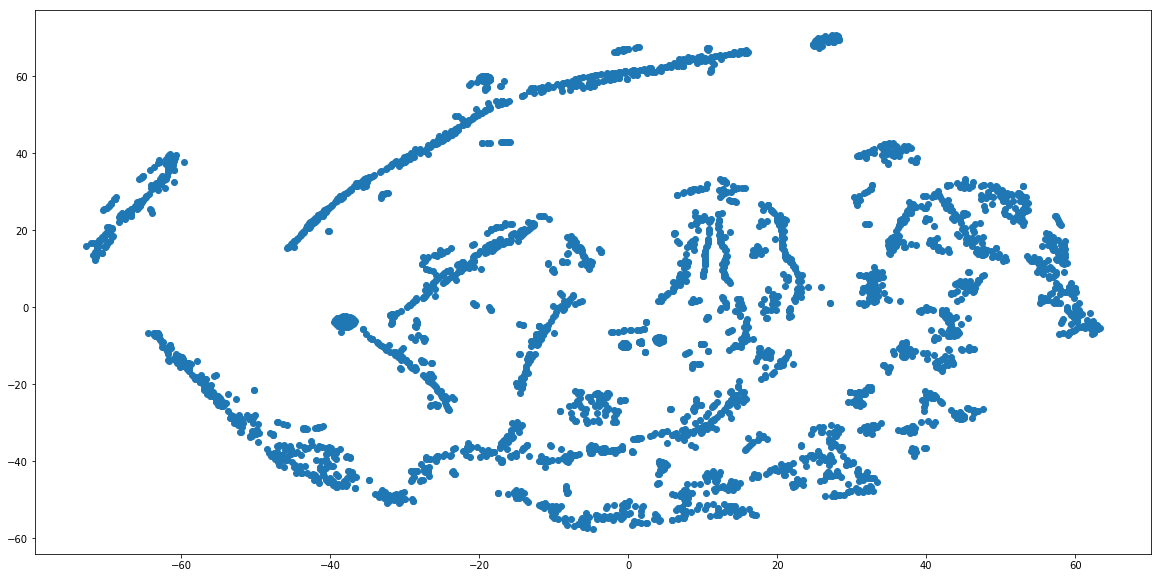

In [310]:
plt.figure(figsize=(20,10))
plt.scatter(embedded_dataset[:, 0], embedded_dataset[:, 1])
plt.show()

In [113]:
from sklearn import preprocessing

In [117]:
scaled_dataset = pd.DataFrame(preprocessing.StandardScaler().fit_transform(dataset), index=dataset.index, columns=dataset.columns)

In [119]:
scaled_dataset.head()

,has_age,has_education,has_location,cnt_friends,cnt_groups,avg_group_size,avg_friend_degree,kmeans_labels,dbscan_labels
id,,,,,,,,,
10938483,0.575159,1.210747,0.37556,-0.362507,-0.268377,-2.356405,-0.822843,-0.127489,-0.267462
280452,-1.738649,1.210747,0.37556,0.736814,-0.112940,-2.356405,-0.943860,-0.127489,-0.267462
5033,0.575159,-0.825936,0.37556,-0.141342,-0.112940,-2.356405,0.257871,-0.127489,-0.267462
7523,0.575159,-0.825936,0.37556,0.345222,-0.112940,-2.356405,2.270850,-0.127489,1.114425
11797,0.575159,-0.825936,0.37556,-0.024254,-0.014769,-2.356405,2.270850,-0.127489,1.114425


## Apply clustering to the data

In [31]:
def labels_nodes(fit_clustering, node_ids):
    labels = set(fit_clustering.labels_)
    n_clusters = len(labels)
    res = {label: [] for label in labels}
    for ind, node_id in enumerate(node_ids):
        res[fit_clustering.labels_[ind]].append(node_id)
    
    res = {n_clusters - key: value for key, value in res.items()}
    return res

In [32]:
def cluster_graph(graph, data=None, cl_type='spectral', draw_each=False, pos=None):
    if cl_type == 'spectral':
        cl_params = {'affinity': 'precomputed'}
        data = nx.adj_matrix(graph)
        clustering = SpectralClustering
    elif cl_type == 'kmeans':
        if data is None:
            raise TypeError("'data' cannot be None")
        cl_params = {}
        clustering = KMeans
    else:
        raise ValueError("'cl_type' must either be 'spectral' or 'kmeans'")
    
    clusterings = []
    for k in range(2, 10):
        cl = clustering(n_clusters=k, **cl_params).fit(data)
        clusterings.append(cl)
        
        print('at {} clusters we get {} silhouette'.format(k, silhouette_score(data, cl.labels_)))
        print('clusters:')
        print({label: len([i for i in cl.labels_ if i == label]) for label in range(cl.n_clusters)})
        
        if draw_each:
            if not pos:
                raise ValueError('You must specify drawing positions')
            drawing_labels = labels_nodes(cl, graph)
            draw_graph_waves(graph, pos, 'graph_{}_{}'.format(cl_type, k), drawing_labels)
    
    best_clustering = max(clusterings, key = lambda clustering: silhouette_score(data, clustering.labels_))
        
    return best_clustering, labels_nodes(best_clustering, graph)

#### SPECTRAL

In [45]:
%%time
spectral_clustering, spectral_labels_nodes = cluster_graph(graph_piece, draw_each=False, pos=pos_shell)

at 2 clusters we get 0.932726682393105 silhouette
clusters:
{0: 3688, 1: 1}
at 3 clusters we get 0.8785709819277412 silhouette
clusters:
{0: 3687, 1: 1, 2: 1}
at 4 clusters we get 0.878720072930632 silhouette
clusters:
{0: 3686, 1: 1, 2: 1, 3: 1}
at 5 clusters we get 0.8302552551310379 silhouette
clusters:
{0: 3671, 1: 1, 2: 1, 3: 1, 4: 15}
at 6 clusters we get 0.7123912687463819 silhouette
clusters:
{0: 3672, 1: 1, 2: 1, 3: 1, 4: 1, 5: 13}
at 7 clusters we get 0.7124897434218614 silhouette
clusters:
{0: 3672, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 12}
at 8 clusters we get 0.7126916910209763 silhouette
clusters:
{0: 3671, 1: 1, 2: 1, 3: 1, 4: 1, 5: 12, 6: 1, 7: 1}
at 9 clusters we get 0.7126098587897507 silhouette
clusters:
{0: 1, 1: 1, 2: 3672, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 10}
CPU times: user 14.9 s, sys: 15.8 s, total: 30.7 s
Wall time: 13.3 s


In [252]:
spectral_clustering = SpectralClustering(n_clusters=5, affinity='precomputed').fit(nx.adj_matrix(graph_piece))
spectral_labels_nodes = labels_nodes(spectral_clustering, graph_piece)

In [263]:
scaled_dataset['spectral_labels'] = pd.Series(index=list(graph_piece.nodes()), data=spectral_clustering.labels_)
dataset['spectral_labels'] = scaled_dataset['spectral_labels']

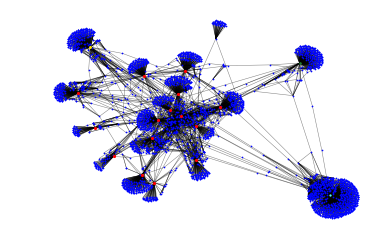

In [257]:
draw_graph_waves(graph_piece, pos_spring, 'graph_spring_spectral', spectral_labels_nodes)

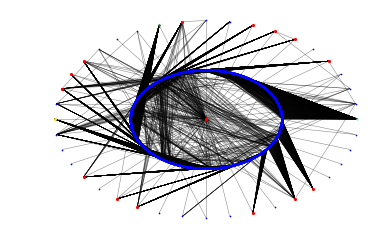

In [345]:
draw_graph_waves(graph_piece, pos_shell, 'graph_shell_spectral', spectral_labels_nodes)

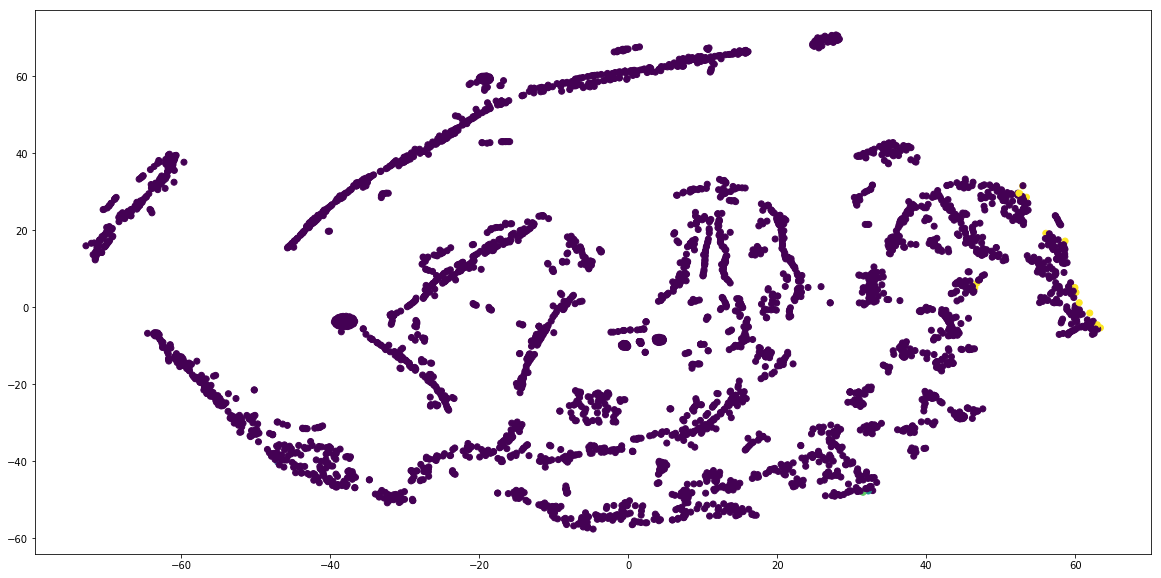

In [321]:
plt.figure(figsize=(20,10))
plt.scatter(embedded_dataset[:, 0], embedded_dataset[:, 1], c=dataset['spectral_labels'])
plt.show()

#### KMEANS

In [121]:
%%time
kmeans_clustering, kmeans_labels_nodes = cluster_graph(graph_piece, 
                                                       scaled_dataset[clustering_features], 
                                                       'kmeans', 
                                                       draw_each=False)

at 2 clusters we get 0.3551667392116123 silhouette
clusters:
{0: 842, 1: 2847}
at 3 clusters we get 0.3808116253091624 silhouette
clusters:
{0: 561, 1: 2194, 2: 934}
at 4 clusters we get 0.41205707222794846 silhouette
clusters:
{0: 1309, 1: 544, 2: 1392, 3: 444}
at 5 clusters we get 0.43045528622353213 silhouette
clusters:
{0: 1278, 1: 443, 2: 540, 3: 1387, 4: 41}
at 6 clusters we get 0.43542073154059796 silhouette
clusters:
{0: 443, 1: 1383, 2: 537, 3: 1270, 4: 6, 5: 50}
at 7 clusters we get 0.49349736685066825 silhouette
clusters:
{0: 1001, 1: 443, 2: 1150, 3: 533, 4: 10, 5: 52, 6: 500}
at 8 clusters we get 0.5273250985423148 silhouette
clusters:
{0: 533, 1: 1067, 2: 938, 3: 429, 4: 443, 5: 50, 6: 10, 7: 219}
at 9 clusters we get 0.5361365881438116 silhouette
clusters:
{0: 57, 1: 1067, 2: 218, 3: 443, 4: 429, 5: 910, 6: 31, 7: 529, 8: 5}
CPU times: user 7.77 s, sys: 6.35 s, total: 14.1 s
Wall time: 6.55 s


In [124]:
kmeans_clustering.n_clusters

9

In [249]:
kmeans_clustering = KMeans(n_clusters=5).fit(scaled_dataset[clustering_features])
kmeans_labels_nodes = labels_nodes(kmeans_clustering, graph_piece)

In [264]:
scaled_dataset['kmeans_labels'] = pd.Series(index=scaled_dataset.index, data=kmeans_clustering.labels_)
dataset['kmeans_labels'] = scaled_dataset['kmeans_labels']

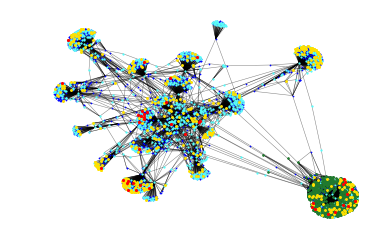

In [346]:
draw_graph_waves(graph_piece, pos_spring, 'graph_spring_kmeans', kmeans_labels_nodes)

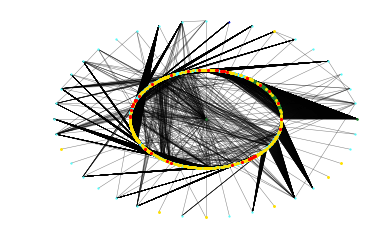

In [347]:
draw_graph_waves(graph_piece, pos_shell, 'graph_shell_kmeans', kmeans_labels_nodes)

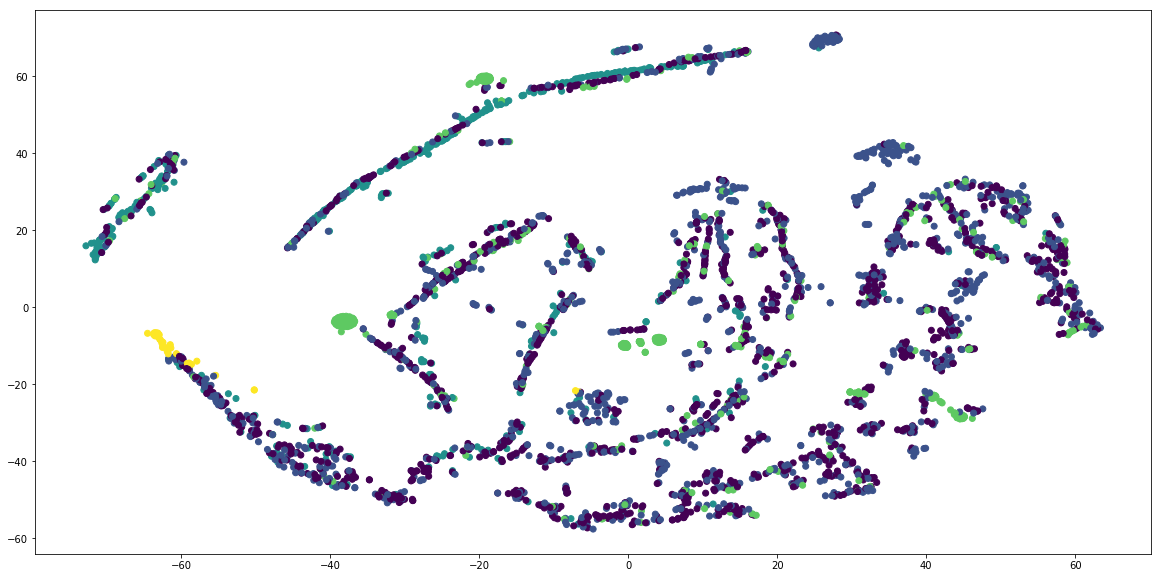

In [348]:
plt.figure(figsize=(20,10))
plt.scatter(embedded_dataset[:, 0], embedded_dataset[:, 1], c=dataset['kmeans_labels'])
plt.show()

#### DBSCAN

In [95]:
from scipy.spatial.distance import pdist, squareform

In [125]:
pd.DataFrame(index=range(5, 100, 5), data=[np.percentile((pdist(scaled_dataset[clustering_features].values)), i) for i in range(5, 100, 5)])

,0
5,0.384951
10,0.676568
15,1.513790
20,2.070574
25,2.143594
30,2.323965
35,2.447260
40,2.856329
45,3.084697
50,3.156545


In [349]:
%%time
dbscan_clustering = DBSCAN(min_samples=5, eps=2.5).fit(scaled_dataset[clustering_features])

CPU times: user 393 ms, sys: 15.3 ms, total: 408 ms
Wall time: 414 ms


In [350]:
dbscan_labels_nodes = labels_nodes(dbscan_clustering, scaled_dataset.index)
len(dbscan_labels_nodes)

5

In [351]:
scaled_dataset['dbscan_labels'] = pd.Series(index=scaled_dataset.index, data=dbscan_clustering.labels_)
dataset['dbscan_labels'] = scaled_dataset['dbscan_labels']

In [343]:
scaled_dataset.groupby('dbscan_labels')[clustering_features].describe()

has_age                                                    \
                count      mean       std       min       25%       50%   
dbscan_labels                                                             
-1               15.0  0.266651  0.814150 -1.738649  0.575159  0.575159   
 0              529.0  0.207749  0.846452 -1.738649  0.575159  0.575159   
 1               34.0 -0.445639  1.166147 -1.738649 -1.738649  0.575159   
 2             2690.0  0.138202  0.905764 -1.738649  0.575159  0.575159   
 3              421.0 -1.117603  1.026541 -1.738649 -1.738649 -1.738649   

                                  has_education             ...     \
                    75%       max         count      mean   ...      
dbscan_labels                                               ...      
-1             0.575159  0.575159          15.0  0.803411   ...      
 0             0.575159  0.575159         529.0 -0.109824   ...      
 1             0.575159  0.575159          34.0 -0.825936   ...      
 2             0.575159  0.575159        2690.0  0.156820   ...      
 3             0.575159  0.575159         421.0 -0.825936   ...      

              avg_group_size           avg_friend_degree                      \
                         75%       max             count      mean       std   
dbscan_labels                                                                  
-1                  0.404576  0.435598              15.0  0.717181  1.351073   
 0                 -2.356405 -2.170272             529.0  1.130026  1.078986   
 1                 -2.232316 -2.170272              34.0  1.240299  1.032642   
 2                  0.466621  0.528665            2690.0 -0.227629  0.817727   
 3                  0.466621  0.528665             421.0 -0.091183  0.895844   

                                                                
                    min       25%       50%       75%      max  
dbscan_labels                                                   
-1            -0.785372 -0.315002 -0.264762  2.270850  2.27085  
 0            -0.943860  0.163460  0.721497  2.270850  2.27085  
 1            -0.468336  0.276416  0.854684  2.270850  2.27085  
 2            -0.945870 -0.701975 -0.467071 -0.163607  2.27085  
 3            -0.936448 -0.666009 -0.288365  0.015100  2.27085  

[5 rows x 56 columns]

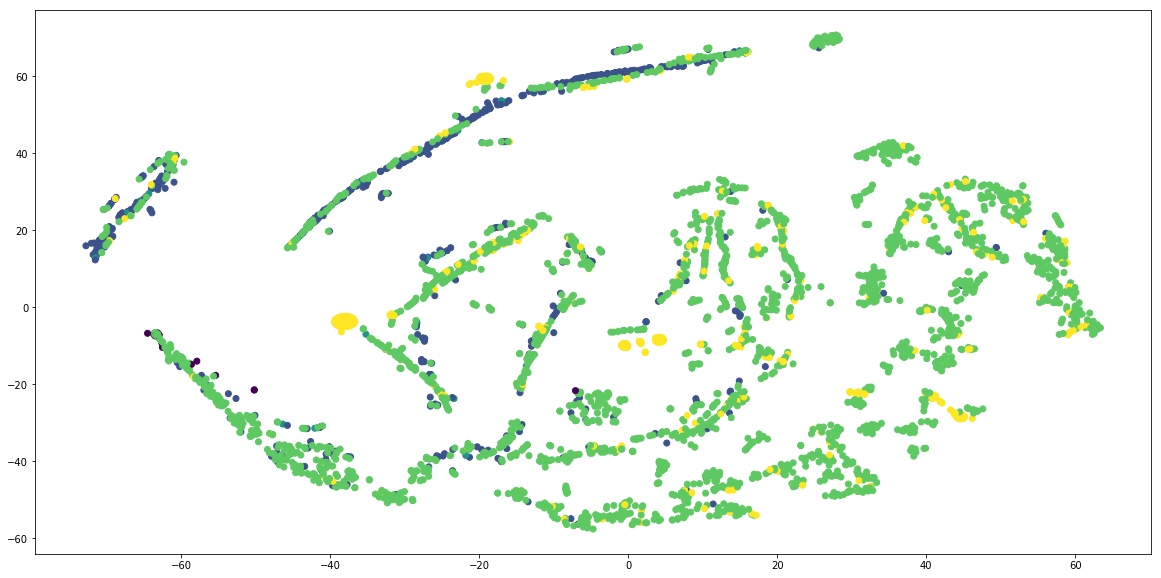

In [352]:
plt.figure(figsize=(20,10))
plt.scatter(embedded_dataset[:, 0], embedded_dataset[:, 1], c=dataset['dbscan_labels'])
plt.show()

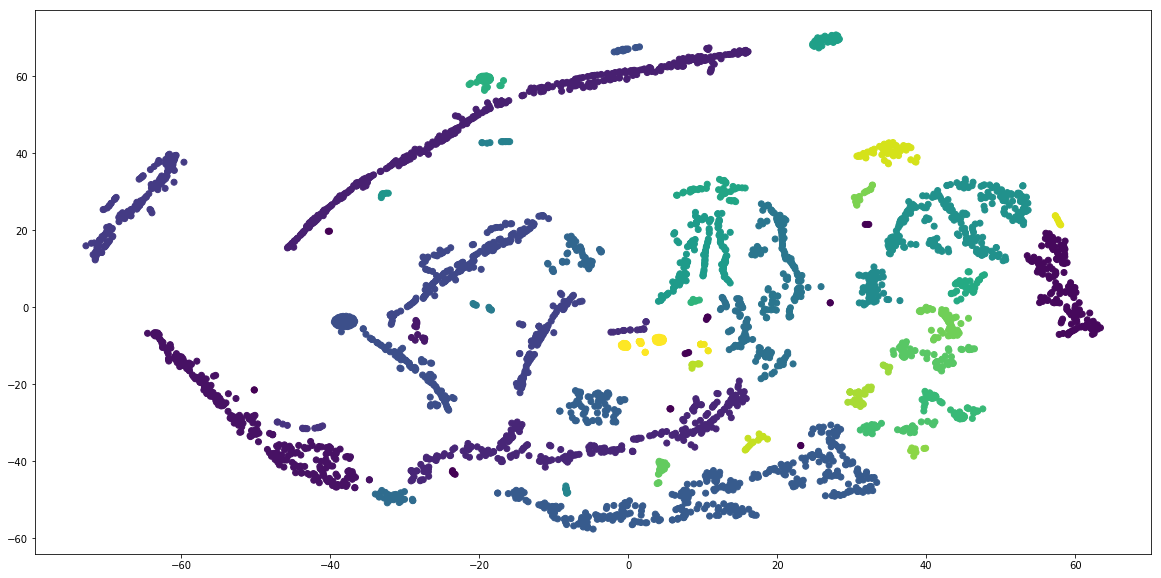

In [324]:
plt.figure(figsize=(20,10))
plt.scatter(embedded_dataset[:, 0], embedded_dataset[:, 1], c=DBSCAN(min_samples=5, eps=2.5).fit_predict(embedded_dataset))
plt.show()

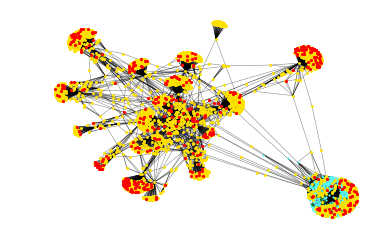

In [353]:
draw_graph_waves(graph_piece, pos_spring, 'graph_dbscan_spring', dbscan_labels_nodes)

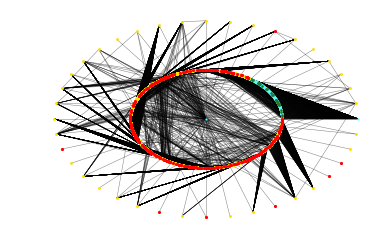

In [354]:
draw_graph_waves(graph_piece, pos_shell, 'graph_dbscan_shell', dbscan_labels_nodes)

### Cluster profiling

In [271]:
nodes_data['kmeans_labels'] = dataset['kmeans_labels']
nodes_data['dbscan_labels'] = dataset['dbscan_labels']
nodes_data['spectral_labels'] = dataset['spectral_labels']

In [277]:
nodes_data.groupby('kmeans_labels').describe().to_csv('kmeans_clusters.csv')

In [276]:
nodes_data.groupby('dbscan_labels').describe().to_csv('dbscan_clusters.csv')

In [275]:
nodes_data.groupby('spectral_labels').describe().to_csv('spectral_clusters.csv')

## Deprecated but possibly useful functions

In [29]:
'''
DEPRECATED IN FAVOUR OF DECORATORS
'''
def get_friends_with_sleep(user_id):
    global requests_count
    if requests_count == 3: # avoid making too many requests
        requests_count = 0
        time.sleep(1)

    try:
        friends = api.friends.get(user_id=user_id, v=api_version)
        requests_count += 1
    except vk.exceptions.VkAPIError as err:
        if err.code in (6, 10): # too many requests per second or internal server error
            time.sleep(1)
            friends = get_friends_with_sleep(user_id)
        else:
            raise err
    if isinstance(friends, list):
        return friends
    return friends['items']

In [36]:
'''
DEPRECATED
'''

def silhouette(k_clusters, data, labels):
    
    s = []
    for vec_ind, vec in enumerate(data):
        vec_cluster = labels[vec_ind]
        b_i = []
        a_i = 0
        for cl_num in range(k_clusters):
            metric = np.average([norm(vec - cl_vec) for cl_vec_ind, cl_vec in enumerate(data) if labels[cl_vec_ind] == cl_num])
            if vec_cluster == cl_num:
                a_i = metric
            else:
                b_i.append(metric)
        b_i = min(b_i)
        
        s_i = (b_i - a_i) / max(a_i, b_i)
        s.append(s_i)
    
    return np.average(s)